In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *

from sklearn.preprocessing import  MinMaxScaler
from statsmodels.tsa.api import SimpleExpSmoothing

from prophet import Prophet

In [2]:
stock_Data_path=pd.ExcelFile('C:/Users/97158/Desktop/Apziva/Project 5-Value Investor/2020Q1Q2Q3Q4-2021Q1.xlsx')

In [3]:
sheet_names=stock_Data_path.sheet_names

dfs={}

for sheet_name in sheet_names:
    df=pd.read_excel(stock_Data_path,sheet_name=sheet_name)
    dfs[sheet_name]=df

In [4]:
sheet_names

['Russia - Sberbank Rossii PAO (S',
 'Turkey - Koc Holding AS (KCHOL)',
 'Egypt - Medinet Nasr Housing (M',
 'Brazil - Minerva SABrazil (BEEF',
 'Argentina - Pampa Energia SA (P',
 'Colombia - Cementos Argos SA (C',
 'South Africa - Impala Platinum ',
 'South Korea - Dongkuk Steel Mil']

In [5]:
dfs[sheet_names[0]]

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030
...,...,...,...,...,...,...,...
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010


In [6]:
Russia=dfs[sheet_names[0]].iloc[:-1,:]
Turkey=dfs[sheet_names[1]].iloc[:-1,:]
Egypt=dfs[ sheet_names[2]].iloc[:-1,:]
Brazil=dfs[sheet_names[3]].iloc[:-1,:]
Argentina=dfs[sheet_names[4]].iloc[:-1,:]
Colombia=dfs[sheet_names[5]].iloc[:-1,:]
South_Africa=dfs[sheet_names[6]].iloc[:-1,:]
South_Korea=dfs[sheet_names[7]].iloc[:-1,:]

In [7]:
Russia[['Country', 'Stock']] = pd.DataFrame([['Russia', 'Sberbank_Rossii_PAO']], index=Russia.index)
Turkey[['Country', 'Stock']] = pd.DataFrame([['Turkey', 'Koc_Holding_AS']], index=Turkey.index)
Egypt[['Country', 'Stock']] = pd.DataFrame([['Egypt', 'Medinet_Nasr_Housing']], index=Egypt.index)
Brazil[['Country', 'Stock']] = pd.DataFrame([['Brazil', ' Minerva_SABrazil']], index=Brazil.index)
Argentina[['Country', 'Stock']] = pd.DataFrame([['Argentina', 'Pampa_Energia_SA']], index=Argentina.index)
Colombia[['Country', 'Stock']] = pd.DataFrame([['Colombia', 'Cementos_Argos_SA']], index=Colombia.index)
South_Africa[['Country', 'Stock']] = pd.DataFrame([['South_Africa', 'Impala_Platinum']], index=South_Africa.index)
South_Korea[['Country', 'Stock']] = pd.DataFrame([['South_Korea', 'Dongkuk_Steel_Mil']], index=South_Korea.index)

C:\Users\97158\AppData\Local\Temp\ipykernel_7760\2259727696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Russia[['Country', 'Stock']] = pd.DataFrame([['Russia', 'Sberbank_Rossii_PAO']], index=Russia.index)
C:\Users\97158\AppData\Local\Temp\ipykernel_7760\2259727696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Russia[['Country', 'Stock']] = pd.DataFrame([['Russia', 'Sberbank_Rossii_PAO']], index=Russia.index)
C:\Users\97158\AppData\Local\Temp\ipykernel_7760\2259727696.py:2: SettingWithCopyWarni

In [8]:
Consol_data=pd.concat([Russia,Turkey,Egypt,Brazil,Argentina, Colombia, South_Africa, South_Korea])
data_order=['Stock','Country','Date', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Price']
Consol_data=Consol_data[data_order]
Consol_data['Date']=pd.to_datetime(Consol_data['Date'])
Consol_data

,Stock,Country,Date,Open,High,Low,Vol.,Change %,Price
0,Sberbank_Rossii_PAO,Russia,2021-03-31,294,294.42,290.26,47.00M,-0.0076,291.02
1,Sberbank_Rossii_PAO,Russia,2021-03-30,294.86,295.72,291.5,38.81M,-0.0002,293.25
2,Sberbank_Rossii_PAO,Russia,2021-03-29,289.72,294.09,289.26,43.68M,0.0071,293.3
3,Sberbank_Rossii_PAO,Russia,2021-03-26,288.63,292.75,288.32,56.07M,0.0159,291.22
4,Sberbank_Rossii_PAO,Russia,2021-03-25,286.5,287.03,283.85,35.22M,0.0030,286.66
...,...,...,...,...,...,...,...,...,...
336,Dongkuk_Steel_Mil,South_Korea,2020-01-08,5640,5640,5390,524.10K,-0.0457,5430
337,Dongkuk_Steel_Mil,South_Korea,2020-01-07,5740,5770,5650,303.89K,-0.0070,5690
338,Dongkuk_Steel_Mil,South_Korea,2020-01-06,5890,5890,5680,319.88K,-0.0288,5730
339,Dongkuk_Steel_Mil,South_Korea,2020-01-03,5870,5920,5830,230.40K,0.0085,5900


In [9]:
def vol_converter(data):
    if data.endswith('M'):
        return float(data.rstrip('M'))*1000000
    elif data.endswith('K'):
        return float(data.rstrip('K'))*1000
    elif data.endswith('-'):
        return float(0)
    else :
        return float(data)
    
Consol_data['Vol.']=Consol_data['Vol.'].apply(vol_converter)  

C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1866791531.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Date'] = pd.to_datetime(country_data['Date'])
C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1866791531.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Date'] = pd.to_datetime(country_data['Date'])
C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1866791531.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

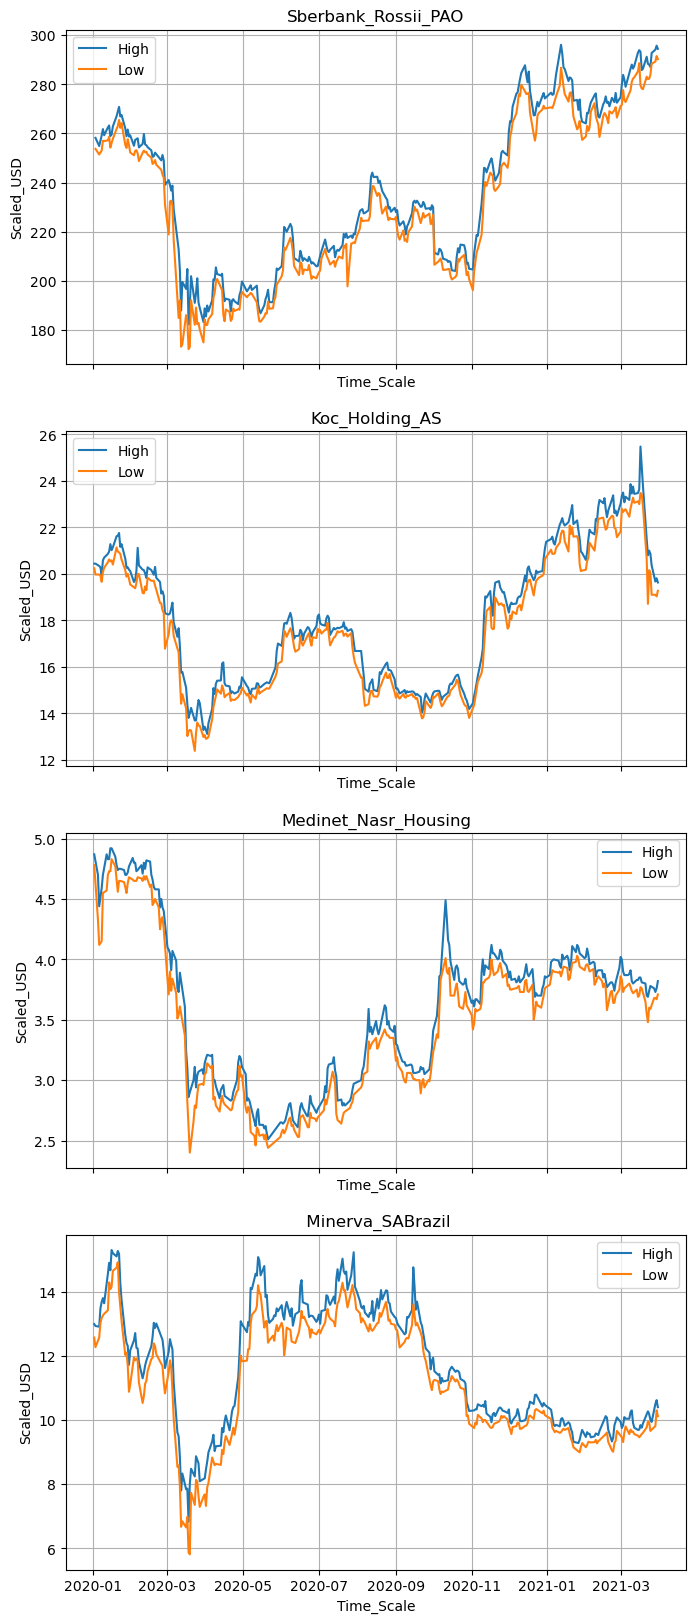

In [10]:
# Plotting charts for 4 stocks

Stock_list=Consol_data['Stock'].unique()[:4]

# Create subplots
fig, axs = plt.subplots(len(Stock_list),1, figsize=(8, 5 * len(Stock_list)), sharex=True)

# Iterate over each country
for i, Stock_name in enumerate(Stock_list):

    # Select data for the current country
    country_data = Consol_data[Consol_data['Stock'] == Stock_name]
    
    # Convert 'Date' column to datetime
    country_data['Date'] = pd.to_datetime(country_data['Date'])

    # Plot 'High' and 'Low' for the current country
    axs[i].plot(country_data['Date'], country_data['High'], label='High')
    axs[i].plot(country_data['Date'], country_data['Low'], label='Low')
    axs[i].set_title(Stock_name)  # Set title as country name
    axs[i].set_xlabel('Time_Scale')
    axs[i].set_ylabel('Scaled_USD')
    axs[i].legend()
    axs[i].grid(True)

# Automatically adjust subplot layout
#plt.tight_layout()
plt.show()

# Moving Average

In [11]:
Consol_data.iloc[:,[0,1,2,-1]]

,Stock,Country,Date,Price
0,Sberbank_Rossii_PAO,Russia,2021-03-31,291.02
1,Sberbank_Rossii_PAO,Russia,2021-03-30,293.25
2,Sberbank_Rossii_PAO,Russia,2021-03-29,293.3
3,Sberbank_Rossii_PAO,Russia,2021-03-26,291.22
4,Sberbank_Rossii_PAO,Russia,2021-03-25,286.66
...,...,...,...,...
336,Dongkuk_Steel_Mil,South_Korea,2020-01-08,5430
337,Dongkuk_Steel_Mil,South_Korea,2020-01-07,5690
338,Dongkuk_Steel_Mil,South_Korea,2020-01-06,5730
339,Dongkuk_Steel_Mil,South_Korea,2020-01-03,5900


In [12]:
def Create_MA(Raw_data, Stock):
    Consol_data=Raw_data[Raw_data['Stock']== Stock]
    MA_Data=Consol_data.iloc[:,[0,1,2,-1]]
    MA_Data=MA_Data.sort_values(by='Date')
    
    MA_Data['7MA']=np.round(MA_Data['Price'].rolling(window=7).mean(),2)
    MA_Data['30MA']=np.round(MA_Data['Price'].rolling(window=30).mean(),2)
    MA_Data['90MA']=np.round(MA_Data['Price'].rolling(window=90).mean(),2)
    return MA_Data

In [13]:
def Plot_MA(MA_Data, Stock):
    MA_Data=MA_Data[MA_Data['Stock']== Stock]
    plt.figure(figsize=(14,6))
    plt.title(Stock+' '+'Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(MA_Data['Date'],MA_Data['Price'],color='orange')
    plt.plot(MA_Data['Date'],MA_Data['7MA'],color='green',linestyle='--')
    plt.plot(MA_Data['Date'],MA_Data['30MA'],color='blue',linestyle='--')
    plt.plot(MA_Data['Date'],MA_Data['90MA'],color='red',linestyle='--')

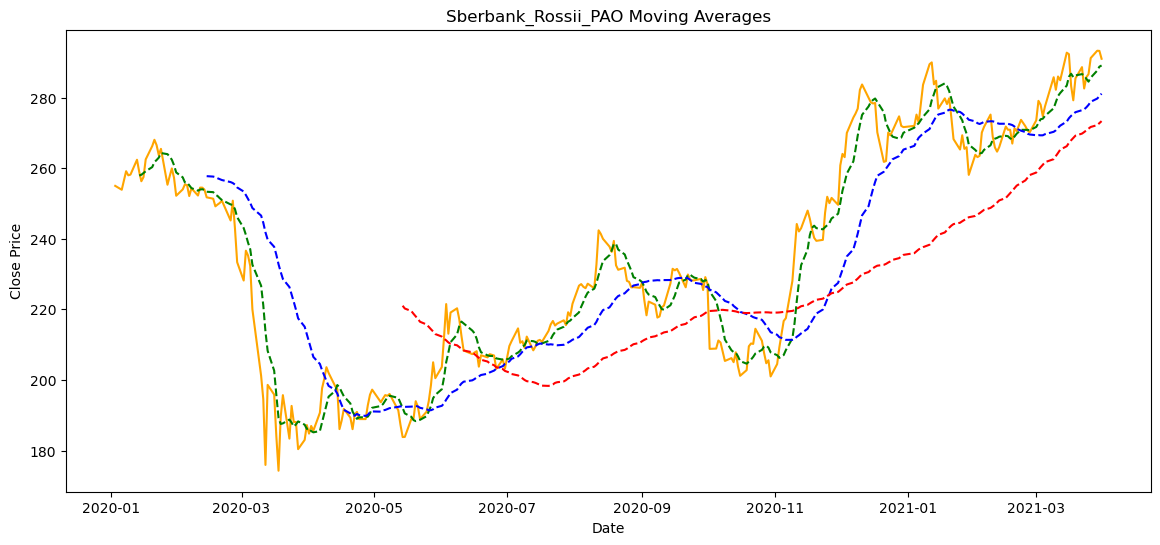

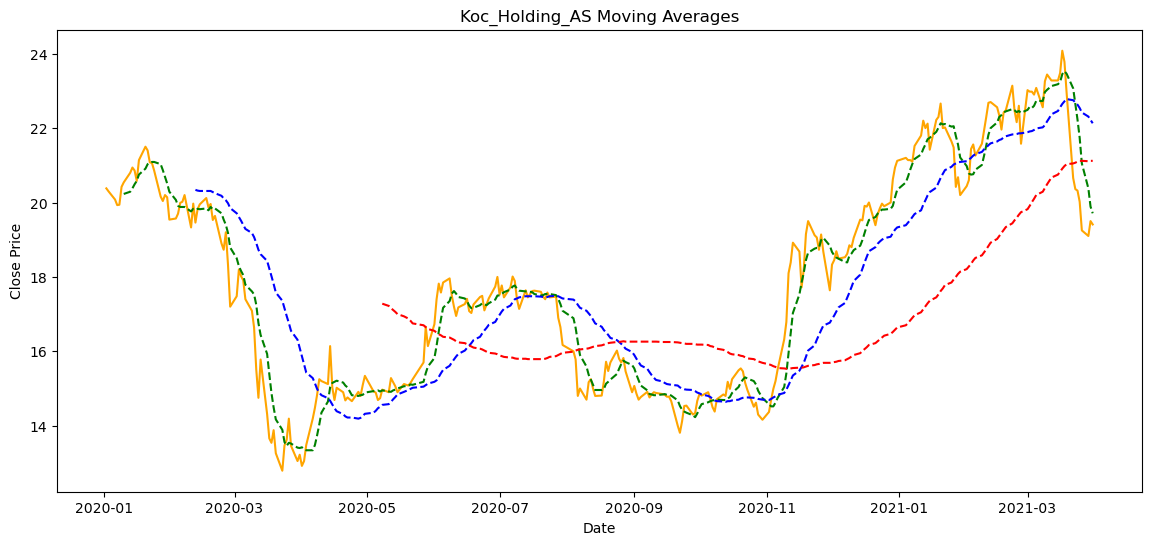

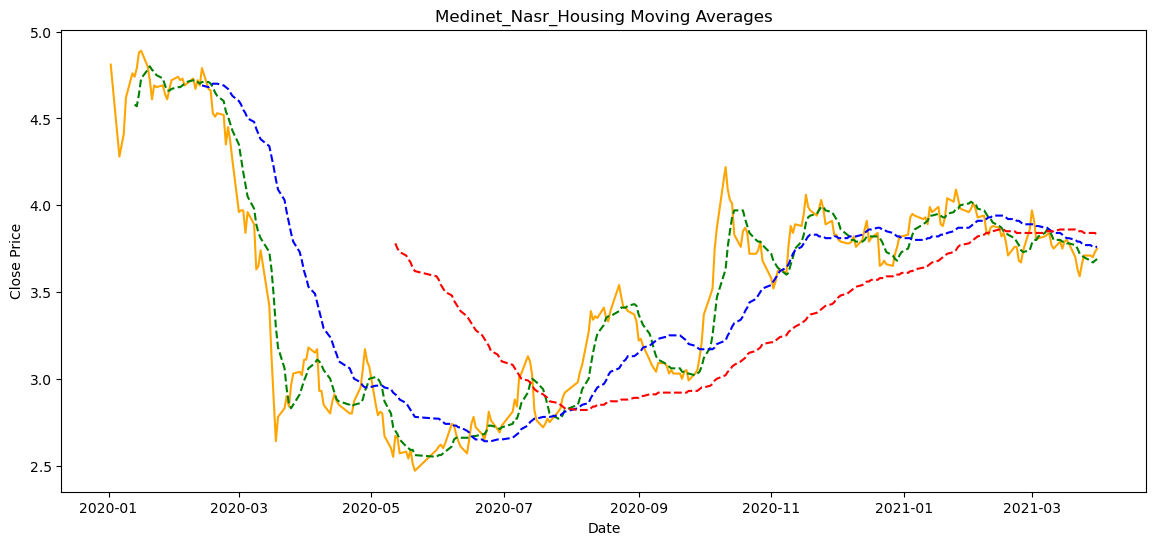

In [28]:
Stocks=Consol_data['Stock'].unique()[:3]
All_MA_Data=pd.DataFrame()

for Stock in Stocks:
    MA_Data= Create_MA(Consol_data, Stock)
    All_MA_Data=pd.concat([All_MA_Data, MA_Data])
    Plot_MA(All_MA_Data, Stock)

# Exponential Moving Average

In [15]:
def Create_EMA(Raw_data, Stock, Span):
    Consol_data=Raw_data[Raw_data['Stock']== Stock]
    EMA_Data=Consol_data.iloc[:,[0,1,2,-1]]
    EMA_Data=EMA_Data.sort_values(by='Date')

    span= Span
    alpha= 2/(span+1)
    
    model=SimpleExpSmoothing(EMA_Data['Price'].values)
    fit_model=model.fit(smoothing_level=alpha, optimized=False)
    EMA_Data['EWMA']=pd.Series(fit_model.fittedvalues).shift(-1)
    return EMA_Data

In [16]:
def Plot_EMA(EMA_Data, Stock):
    EMA_Data=EMA_Data[EMA_Data['Stock']== Stock]
    plt.figure(figsize=(14,6))
    plt.title(Stock+' '+'Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(EMA_Data['Date'],EMA_Data['Price'],color='orange')
    plt.plot(EMA_Data['Date'],EMA_Data['EWMA'],color='green',linestyle='--')

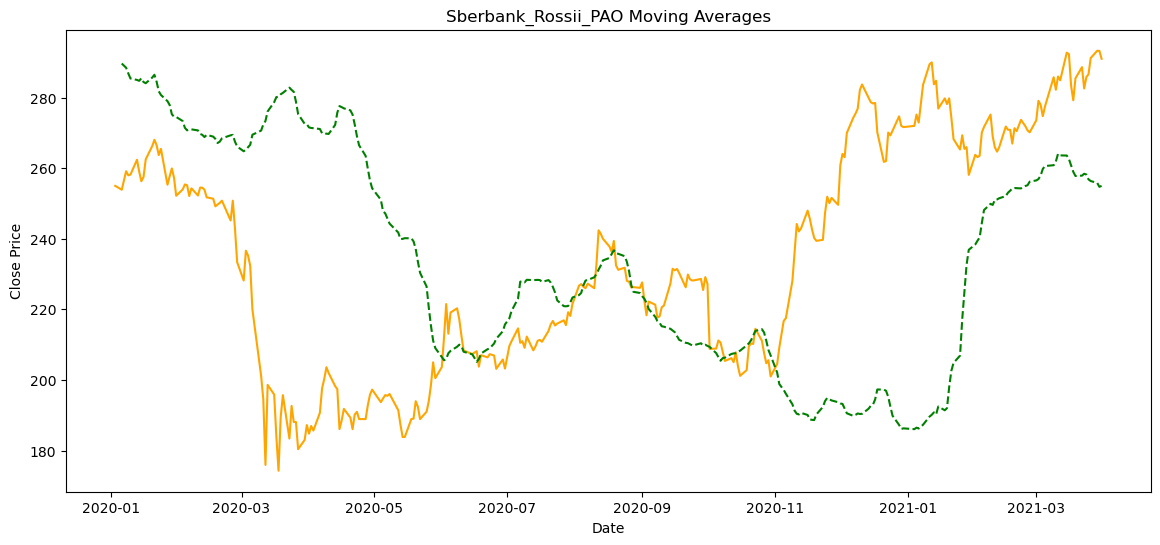

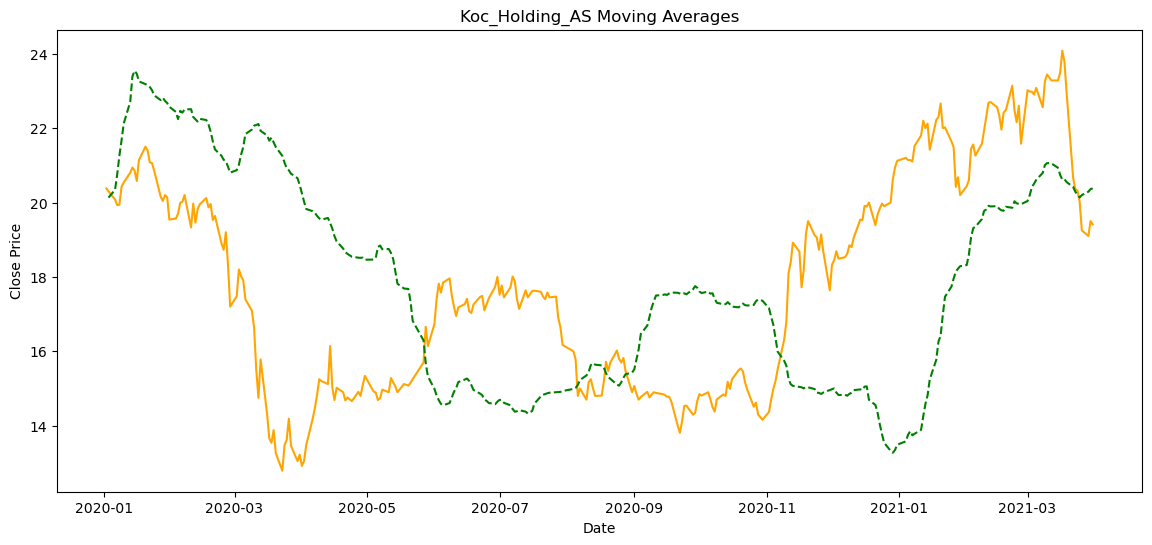

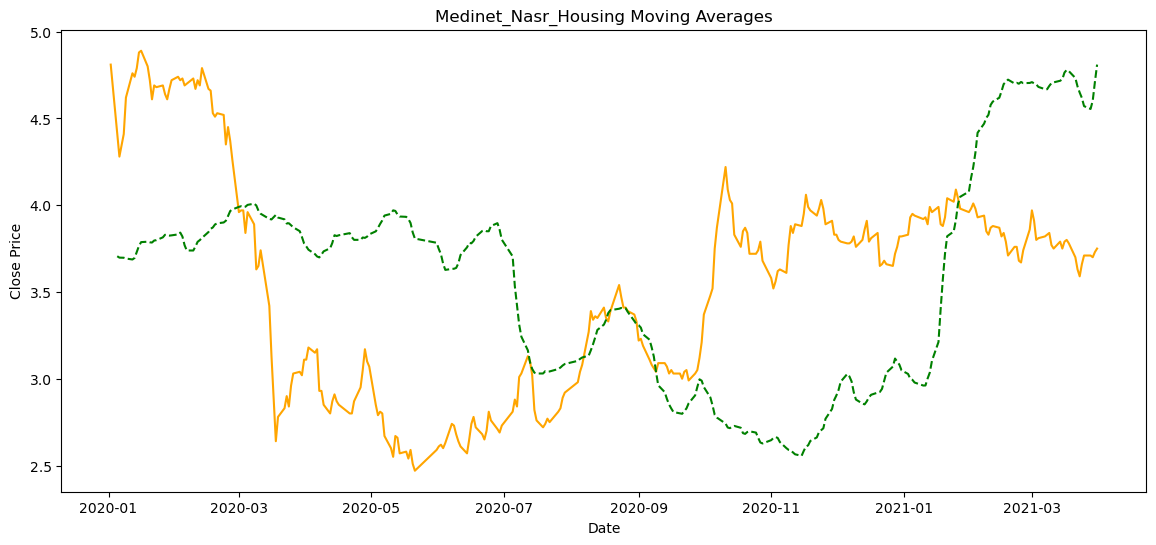

In [17]:
Stocks=Consol_data['Stock'].unique()[:3]
All_EMA_Data=pd.DataFrame()

for Stock in Stocks:
    EMA_Data= Create_EMA(Consol_data, Stock,7)
    All_EMA_Data=pd.concat([All_EMA_Data, EMA_Data])
    Plot_EMA(All_EMA_Data, Stock)

# LSTM Model

In [18]:
# Define the LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',run_eagerly=True)
    return model

In [19]:
def split_sequence(sequence, n_steps):
    X, Y = [], []

    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        Y.append(seq_y)

    return np.array(X), np.array(Y)

In [20]:
def Train_LSTM(Raw_data, Stock, n_steps):
    # Filter data for the current country
    country_data = Raw_data[Raw_data['Stock'] == Stock]
        
    # Extract the price data for the current country
    price_data = country_data['Price'].values.astype(float)
        
    # Normalize the price data
    scaler = MinMaxScaler(feature_range=(0, 1))
    price_data_scaled = scaler.fit_transform(price_data.reshape(-1, 1))

    data_concat=pd.concat([country_data,pd.Series(price_data_scaled.reshape(-1))],axis=1)
        
    Train_data_scaled=data_concat[data_concat['Date']<='2020-12-31']
    Test_data_scaled=data_concat[data_concat['Date']>'2020-12-31']

    Train_price_scaled=Train_data_scaled.iloc[:,-1]
    Train_price_scaled=np.array(Train_price_scaled)

        
    # Split the sequence for the current country
    X_train_country, Y_train_country = split_sequence(Train_price_scaled, n_steps)

    # Reshape the input data
    X_train_country = X_train_country.reshape((X_train_country.shape[0], n_steps, 1))

    # Train the LSTM model
    model = create_lstm_model((X_train_country.shape[1], 1))
    model.fit(X_train_country, Y_train_country, epochs=5, batch_size=2, verbose=0)
    
    return Test_data_scaled, model, scaler, n_steps, Train_data_scaled

In [21]:
def Predict_LSTM(Test_data, model, scaler, n_steps):

    Test_price_scaled=Test_data.iloc[:,-1]
    Test_price_scaled=np.array(Test_price_scaled)

    X_test_country, Y_test_country = split_sequence(Test_price_scaled, n_steps)
    X_test_country = X_test_country.reshape((X_test_country.shape[0], n_steps, 1))

    test_predict= model.predict(X_test_country)
    test_predict= np.round(scaler.inverse_transform(test_predict))

    Predicted_data=Test_data.iloc[n_steps:,[0,1,2,-2]]
    Predicted_data['Test_predicted']=test_predict
    
    return Predicted_data

In [22]:
def Calculate_bands_and_plot(Train_data, test_and_predicted_data,Stock):

    Bband_data=pd.concat([Train_data,test_and_predicted_data])
    Bband_data=Bband_data.sort_values(by='Date',ascending=True)
    Bband_data=Bband_data.iloc[:,2:]
    Bband_data['Date']=[pd.to_datetime(date) for date in Bband_data['Date']]

    Bband_data['SMA']=np.round(Bband_data['Price'].rolling(window=5).mean(),2)
    Bband_data['STD']=np.round(Bband_data['Price'].rolling(window=5).std(),2)

    Bband_data['Upper_Band']=Bband_data['SMA']+(Bband_data['STD']*2)
    Bband_data['Lower_Band']=Bband_data['SMA']-(Bband_data['STD']*2)

    Bband_data['Stock']=Stock

    plt.figure(figsize=(14,6))
    plt.title(Stock)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(Bband_data['Date'],Bband_data['Price'])
    plt.plot(Bband_data['Date'],Bband_data['Test_predicted'])
    plt.plot(Bband_data['Date'],Bband_data['Upper_Band'], color='grey',linestyle='--')
    plt.plot(Bband_data['Date'],Bband_data['Lower_Band'], color='grey',linestyle='--')

    plt.fill_between(Bband_data['Date'],Bband_data['Upper_Band'],Bband_data['Lower_Band'],color='grey',alpha=0.2)
    plt.legend(Bband_data[['Price','Test_predicted','Upper_Band','Lower_Band']], loc='lower right')

    
    return Bband_data

In [23]:
def Make_decision(Bband_data,Stock):
    Bband_data = Bband_data[Bband_data['Stock'] == Stock]
    Decision=[]
    for index, row in Bband_data.iterrows():
        if row['Test_predicted'] > row['Upper_Band']:
            Decision.append("Sell")
        elif row['Test_predicted'] < row['Lower_Band']:
            Decision.append("Buy")
        elif np.isnan(row['Test_predicted']):
            Decision.append("N/A")    
        else:
            Decision.append("Hold")

    Bband_data['Decision']= Decision   
    return Bband_data[['Stock','Date','Price','Test_predicted','Decision']]

2/2 [==============================] - 0s 17ms/step
                 Stock       Date   Price  Test_predicted Decision
9  Sberbank_Rossii_PAO 2021-03-18  279.25           275.0     Hold
8  Sberbank_Rossii_PAO 2021-03-19  285.47           276.0     Hold
7  Sberbank_Rossii_PAO 2021-03-22  288.65           277.0     Hold
6  Sberbank_Rossii_PAO 2021-03-23   282.6           279.0     Hold
5  Sberbank_Rossii_PAO 2021-03-24  285.79           280.0     Hold
2/2 [==============================] - 0s 20ms/step
            Stock       Date  Price  Test_predicted Decision
9  Koc_Holding_AS 2021-03-18  23.78            21.0      Buy
8  Koc_Holding_AS 2021-03-19  22.94            20.0      Buy
7  Koc_Holding_AS 2021-03-22  20.66            20.0      Buy
6  Koc_Holding_AS 2021-03-23  20.36            20.0     Hold
5  Koc_Holding_AS 2021-03-24  20.32            19.0     Hold


C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1332872437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


2/2 [==============================] - 0s 33ms/step
                  Stock       Date Price  Test_predicted Decision
9  Medinet_Nasr_Housing 2021-03-18  3.78             4.0     Sell
8  Medinet_Nasr_Housing 2021-03-21   3.7             4.0     Sell
7  Medinet_Nasr_Housing 2021-03-22  3.63             4.0     Sell
6  Medinet_Nasr_Housing 2021-03-23  3.59             4.0     Sell
5  Medinet_Nasr_Housing 2021-03-24  3.66             4.0     Sell


C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1332872437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


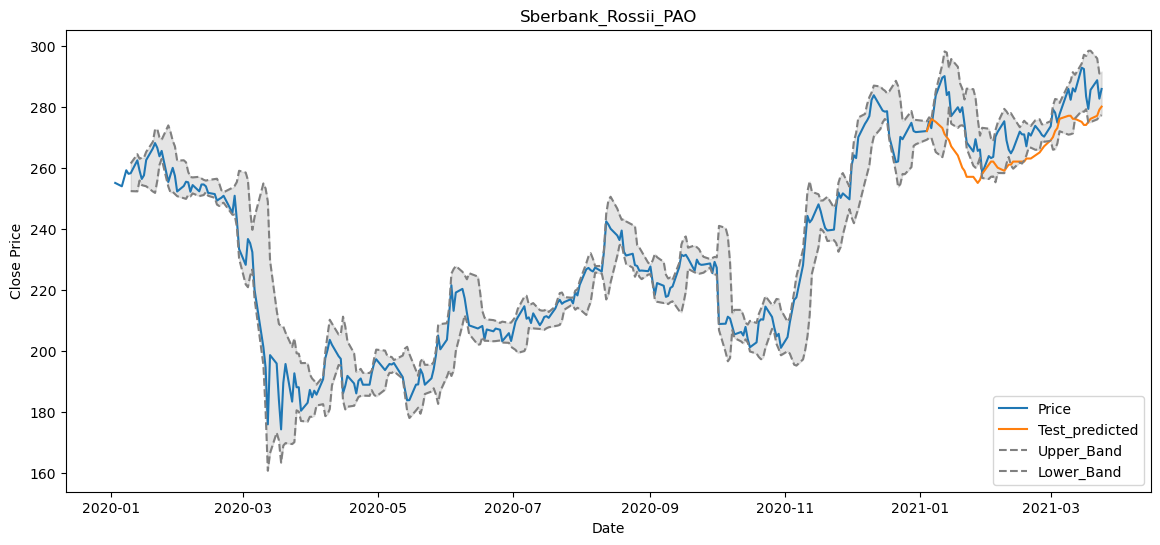

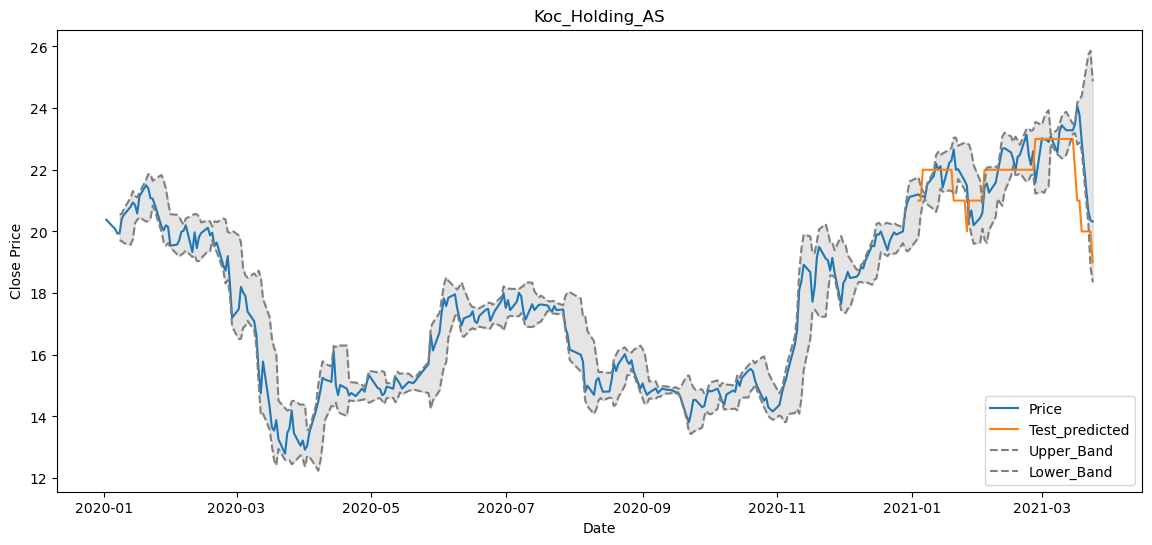

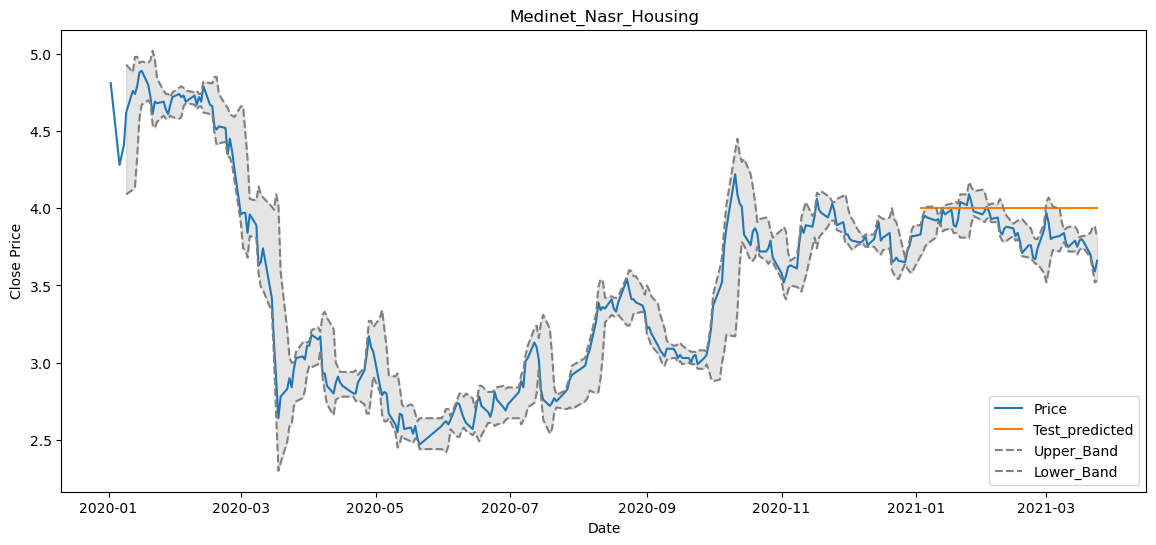

In [24]:
Stocks=Consol_data['Stock'].unique()[:3]
All_Country_Predicted= pd.DataFrame()
All_Bband_data= pd.DataFrame()

for Stock in Stocks:
    Test_data_scaled,  model, scaler, n_steps, Train_data_scaled = Train_LSTM(Consol_data, Stock,n_steps=5)

    Predicted_data = Predict_LSTM(Test_data_scaled,model,scaler,n_steps)

    All_Country_Predicted=pd.concat([All_Country_Predicted,Predicted_data])

    Bband_data= Calculate_bands_and_plot(Train_data_scaled.iloc[:,[0,1,2,-2]],Predicted_data,Stock)

    All_Bband_data=pd.concat([All_Bband_data,Bband_data])
    
    print(Make_decision(All_Bband_data,Stock).tail())
    

In [25]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


print("Test Set RMSE: ",np.round(math.sqrt(mean_squared_error(All_Country_Predicted['Price'],All_Country_Predicted['Test_predicted'])),3))
print("Test Set MAPE: ",np.round(math.sqrt(mean_absolute_percentage_error(All_Country_Predicted['Price'],All_Country_Predicted['Test_predicted'])),3))

Test Set RMSE:  5.767
Test Set MAPE:  0.182


# Facebook Prophet

In [26]:
def Train_and_Predict_Prophet(Stock, Raw_data, days_to_predict):
    
    country_data = Raw_data[Raw_data['Stock'] == Stock]
    Train_data=country_data[country_data['Date']<='2020-12-31']
    Test_data=country_data[country_data['Date']>'2020-12-31']
    
    Train_data= Train_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
    Train_data_prohphet=Train_data.rename(columns={'Date':'ds', 'Price':'y'})


    model=Prophet()
    model.fit(Train_data_prohphet.iloc[:,-2:])
    future=model.make_future_dataframe(periods=days_to_predict, freq='D',include_history=False)
    forecast=model.predict(future)


    Test_data_scaled=Test_data.sort_values(by='Date')
    forecast=forecast.rename(columns={'ds':'Date','yhat':'Test_predicted'})
    forecast=forecast[['Date','Test_predicted']]
    test_and_predicted_data=pd.merge(Test_data_scaled.iloc[:,[0,1,2,-1]],forecast,on='Date')


    return Train_data, test_and_predicted_data, Train_data_prohphet

17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing


                  Stock       Date   Price  Test_predicted Decision
56  Sberbank_Rossii_PAO 2021-03-25  286.66      363.121914     Sell
57  Sberbank_Rossii_PAO 2021-03-26  291.22      363.236523     Sell
58  Sberbank_Rossii_PAO 2021-03-29   293.3      365.754238     Sell
59  Sberbank_Rossii_PAO 2021-03-30  293.25      368.305605     Sell
60  Sberbank_Rossii_PAO 2021-03-31  291.02      370.103616     Sell
             Stock       Date  Price  Test_predicted Decision
58  Koc_Holding_AS 2021-03-25  20.02       26.856006     Sell
59  Koc_Holding_AS 2021-03-26  19.25       26.880149     Sell
60  Koc_Holding_AS 2021-03-29   19.1       27.061871     Sell
61  Koc_Holding_AS 2021-03-30   19.5       27.228336     Sell
62  Koc_Holding_AS 2021-03-31  19.41       27.262399     Sell


C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1332872437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision
17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\97158\AppData\Local\Temp\ipykernel_7760\1332872437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bband_data['Decision']= Decision


                   Stock       Date Price  Test_predicted Decision
57  Medinet_Nasr_Housing 2021-03-25  3.71        4.390832     Sell
58  Medinet_Nasr_Housing 2021-03-28  3.71        4.421591     Sell
59  Medinet_Nasr_Housing 2021-03-29   3.7        4.411495     Sell
60  Medinet_Nasr_Housing 2021-03-30  3.73        4.437991     Sell
61  Medinet_Nasr_Housing 2021-03-31  3.75        4.434216     Sell


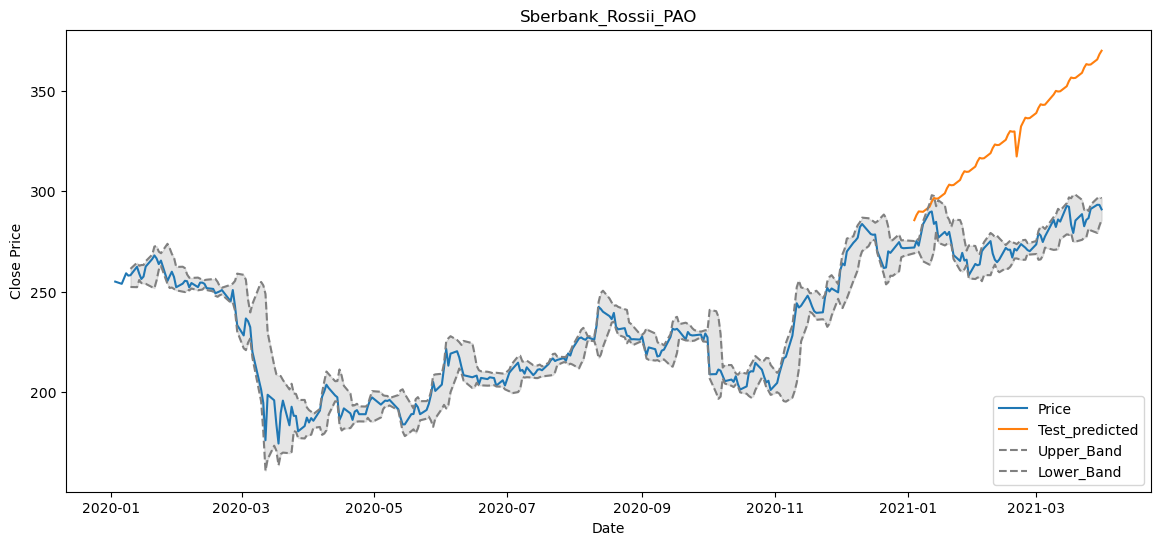

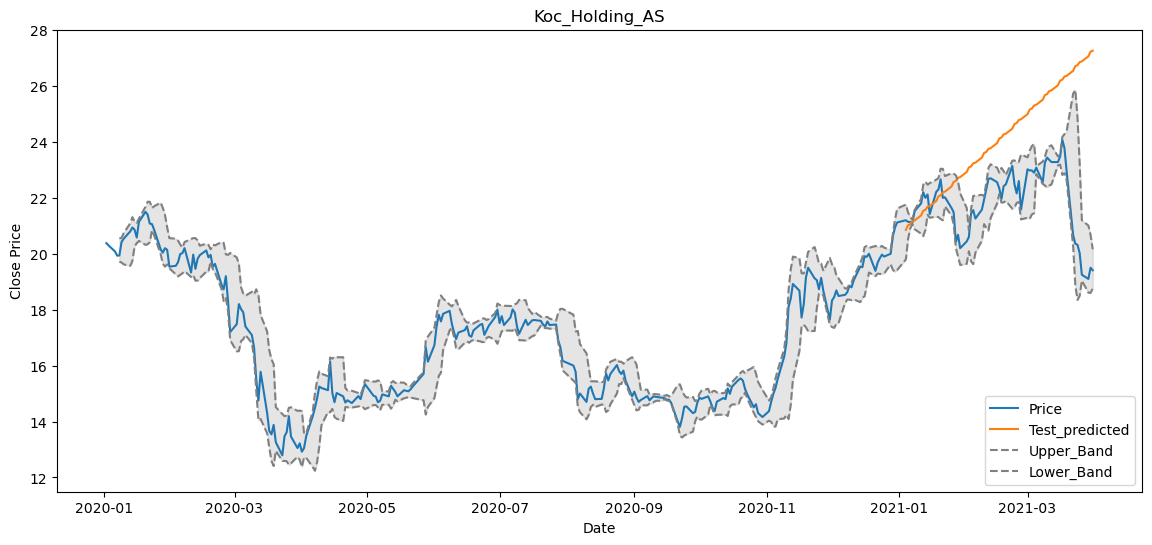

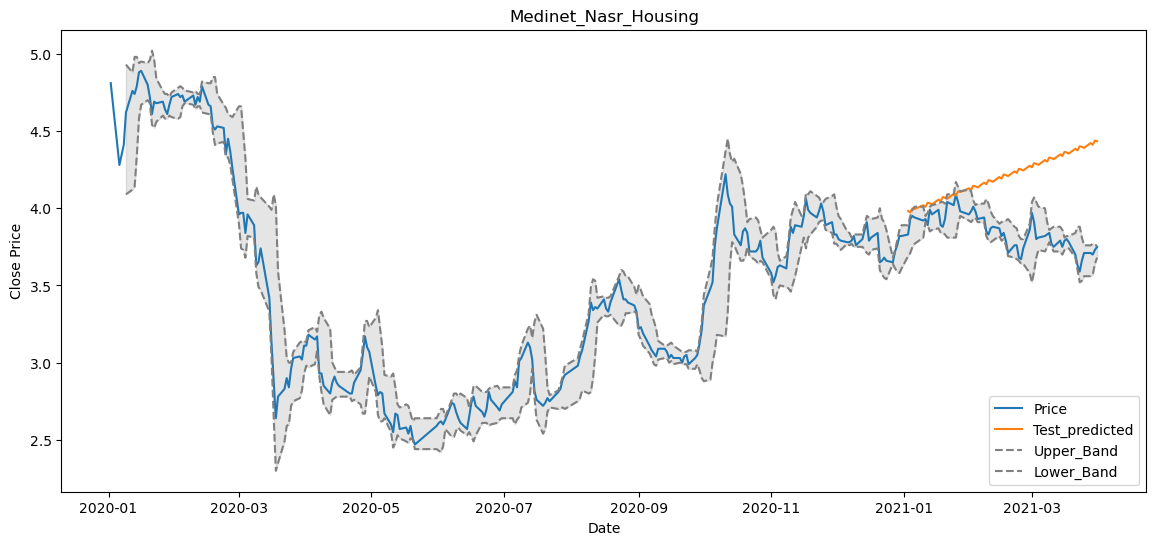

In [27]:
Stocks=Consol_data['Stock'].unique()[:3]
All_Bband_data= pd.DataFrame()


for Stock in Stocks:    
    Train_data, test_and_predicted_data, Train_data_prohphet = Train_and_Predict_Prophet(Stock, Consol_data,  91)
    Bband_data= Calculate_bands_and_plot(Train_data,test_and_predicted_data, Stock )
    All_Bband_data=pd.concat([All_Bband_data,Bband_data])
    print(Make_decision(All_Bband_data,Stock).tail())
    